# Results figure --- seasonal spatial variation in continental and glacial river contributions 

In [1]:
import pickle
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cmocean

%matplotlib inline

#### Parameters:

In [2]:
# Domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# Results folders:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202206/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202206/'
folder_cont = '/data/brogalla/run_storage/river-continental-202206/'

# Boundary coordinates:
xmin=imin+1; ymin=jmin+1;
r1i = 1520-xmin;                      r1j = np.arange(505-ymin,673-ymin)
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin #Nares
P1i = 1585-xmin;                      P1j = np.arange(485-ymin,538-ymin)  #Parry channel
P1j = P1j[10:-5]; N1i = N1i[11:-8]

land_color = '#a9a7a2'

# Color map:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(171/N, 1, N)
vals_cont[:, 1] = np.linspace(92/N, 1, N)
vals_cont[:, 2] = np.linspace(41/N, 1, N)
cont_cmap = ListedColormap(vals_cont).reversed()

vals_glac = np.ones((N, 4))
vals_glac[:, 0] = np.linspace(8/N, 1, N)
vals_glac[:, 1] = np.linspace(115/N, 1, N)
vals_glac[:, 2] = np.linspace(180/N, 1, N)
glac_cmap = ListedColormap(vals_glac).reversed()

#### Load files:

In [3]:
# ANHA12 mesh:
mesh          = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask         = np.array(mesh.variables['tmask'])
land_mask     = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
tmask_full    = np.empty((12,50,isize,jsize))
tmask_full[:] = tmask[0,:,imin:imax,jmin:jmax]
lon_ANHA12    = np.array(mesh.variables['nav_lon'])
lat_ANHA12    = np.array(mesh.variables['nav_lat'])
e3t           = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
hdept         = np.array(mesh.variables['hdept'])[0,imin:imax,jmin:jmax]

In [4]:
# Mn model grid:
ref         = nc.Dataset('/data/brogalla/run_storage/Mn-reference-202206/ANHA12_ref-2002_20220422/ANHA12_EXH006_2002_monthly.nc','r')
lon_sub     = np.array(ref.variables['nav_lon'])
lat_sub     = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

#### Functions:

In [5]:
def load_Mn_results():
    
    file = f'climatology.nc'
    path_ref  = f'{folder_ref}/{file}'
    path_glac = f'{folder_glac}/{file}'
    path_cont = f'{folder_cont}/{file}'
    
    with xr.open_dataset(f'{path_ref}') as monthly_ref:
        dmn_ref = monthly_ref['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_glac}') as monthly_glac:
        dmn_glac = monthly_glac['dissolmn'].values[:,0,:,:,:]
        
    with xr.open_dataset(f'{path_cont}') as monthly_cont:
        dmn_cont = monthly_cont['dissolmn'].values[:,0,:,:,:]
    
    return dmn_ref, dmn_glac, dmn_cont

Calculate the proportional contribution of glacial rivers to each grid cell:

$$ prop = \frac{Mn_{glacier}-Mn_{base}}{Mn_{base}} = \frac{Mn_{glacier}}{Mn_{base}} - 1 $$

In [6]:
def calculate_prop(dmn_riv_off, dmn_riv_on):
    # Input arguments:
    # - dmn_riv_on (t,z,y,x) --- concentration of dMn with riverine contribution on
    # - dmn_riv_off(t,z,y,x) --- concentration of dMn with rivers off
    
    # Contribution of rivers / total concentration (with rivers on):
    # should be an elementwise operation
    prop_river  = np.divide(dmn_riv_on - dmn_riv_off, dmn_riv_off)*100*2 # times two so that 100% 
    
    # Output:
    # - prop_river(t,z,y,x)  --- proportional contribution of river to observed [dMn]
    return prop_river

In [7]:
def calculate_depth_weighted(var, levels=(0,16)):
    # Input arguments:
    # - var(t,z,y,x) --- variable 
    
    e3t_tile         = np.tile(e3t, (12,1,1,1))
    var_weighted     = var[:,levels[0]:levels[1],:,:]*e3t_tile[:,levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]):
    depth_bottom     = np.copy(hdept)
    depth_bottom[depth_bottom == 0] = np.nan
    # where bottom is deeper than levels[1], use depth of levels[1]
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1] 
                 
    # calculate average:
    var_weighted_ave = np.nansum(var_weighted, axis=1) / depth_bottom
    
    # Output:
    # - var_weighted_ave(t,y,x) --- depth-weighted average of variable for each horizontal grid location
    return var_weighted_ave

#### Calculations:

In [8]:
dmn_ref, dmn_glac, dmn_cont = load_Mn_results()

depth_weighted_ref  = calculate_depth_weighted(dmn_ref, levels=(0,16))
depth_weighted_glac = calculate_depth_weighted(dmn_glac, levels=(0,16))
depth_weighted_cont = calculate_depth_weighted(dmn_cont, levels=(0,16))

glacier_prop     = calculate_prop(depth_weighted_ref, depth_weighted_glac)
continental_prop = calculate_prop(depth_weighted_ref, depth_weighted_cont)
# continental_prop = calculate_prop(dmn_ref[:,0,:,:], dmn_cont[:,0,:,:])

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
# Mask small values:
ma_glac = np.ma.masked_where((glacier_prop < 0.05), glacier_prop)
ma_cont = np.ma.masked_where((continental_prop < 0.05), continental_prop)

#### Figures

In [23]:
glac_plot = (np.ma.mean(ma_glac[:,:,:]/100, axis=0)*0.49/(1-0.49*np.ma.mean(ma_glac[:,:,:]/100, axis=0)))*100

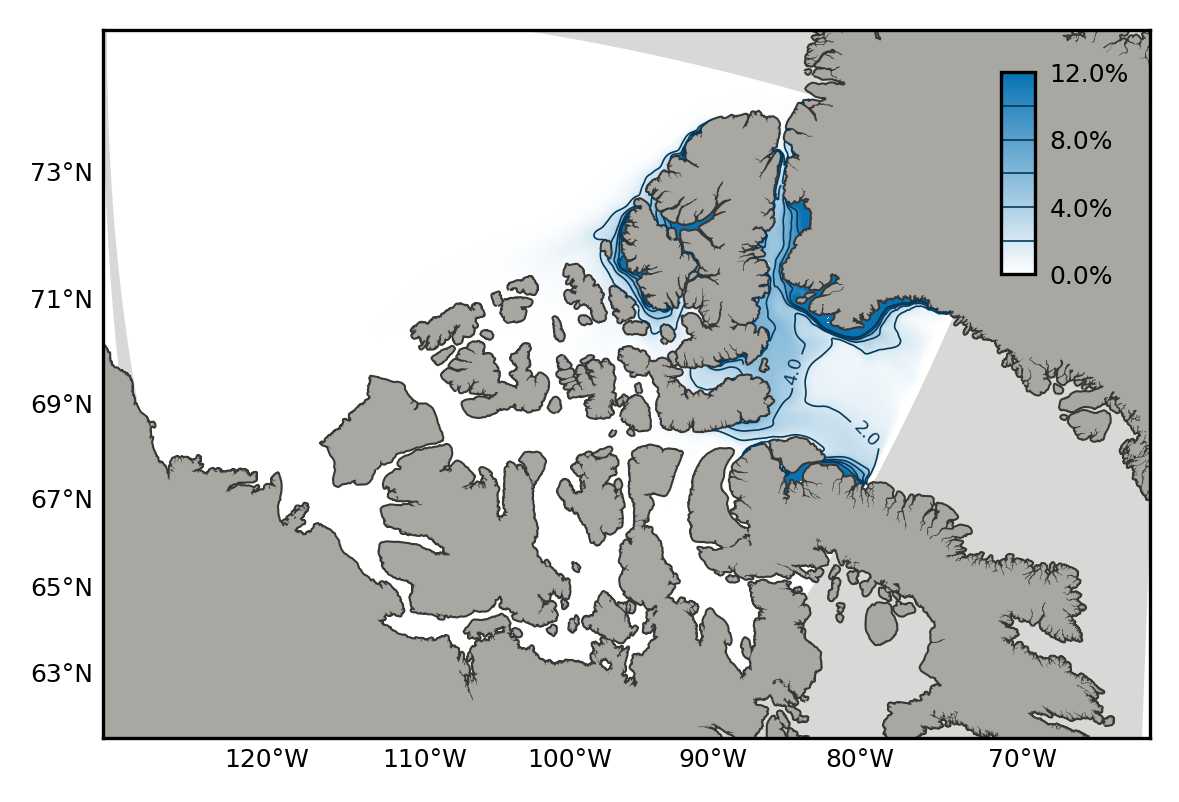

In [25]:
#2020-01
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

vmin_glac = 0; vmax_glac = 12;
CS1 = proj1.pcolormesh(x_model, y_model, glac_plot, vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

# Contour lines:
glac_levels = [2,4,6,8,10]
glac = proj1.contour(x_model, y_model, glac_plot, levels=glac_levels, colors='#04395a', linewidths=0.4)

# Draw domain boundaries:
# consider adding plus rimwidth of boundary 
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[0,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,-1], color='#d8d8d6')
ax1.fill_between(x_ANHA12[imax,:], y_ANHA12[imax,:], y_ANHA12[-1,:], color='#d8d8d6')

# Contour line labels:
manual_locations_glac = [(2.5e6, 1.0e6), (2.22e6, 1.2e6)]
ax1.clabel(glac, [2,4,6,8,10], inline=1, manual=manual_locations_glac, fontsize=4.3, fmt='%1.1f')

# Colorbars:
cbaxes1 = fig.add_axes([0.79, 0.60, 0.025, 0.18])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=[0,4,8,12])
CBar1.add_lines(glac)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S12-projected-glacial.jpg', bbox_inches='tight', dpi=300)

In [12]:
glac_plot = np.ma.mean(ma_glac[:,:,:], axis=0)*0.49

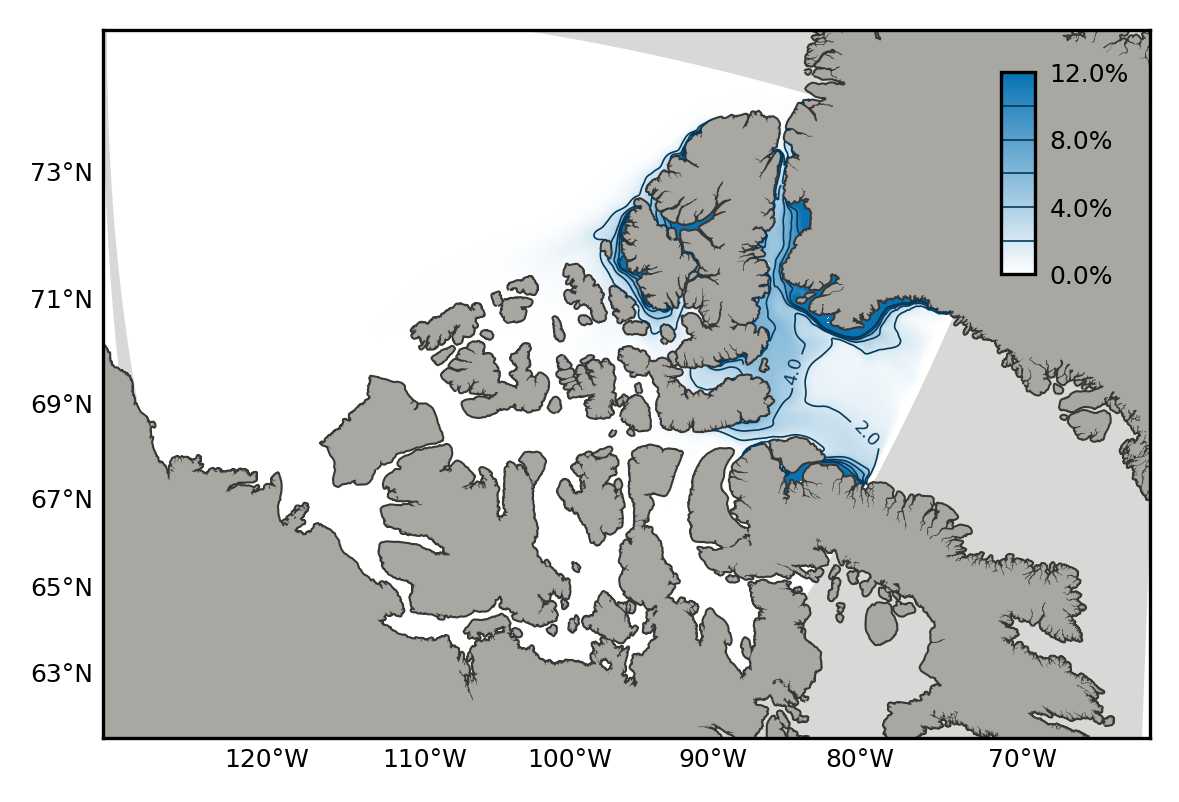

In [26]:
#2020-01
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/rivers-CAA.pickle','rb'))

#---------------------
x_model, y_model   = proj1(lon_sub, lat_sub)
x_ANHA12, y_ANHA12 = proj1(lon_ANHA12, lat_ANHA12)

vmin_glac = 0; vmax_glac = 12;
CS1 = proj1.pcolormesh(x_model, y_model, glac_plot, vmin=vmin_glac, vmax=vmax_glac, cmap=glac_cmap)

# Contour lines:
glac_levels = [2,4,6,8,10]
glac = proj1.contour(x_model, y_model, glac_plot, levels=glac_levels, colors='#04395a', linewidths=0.4)

# Draw domain boundaries:
# consider adding plus rimwidth of boundary 
ax1.fill_between(x_ANHA12[imin,:], y_ANHA12[imin,:], y_ANHA12[0,:], color='#d8d8d6')
ax1.fill_between(x_ANHA12[:,jmax], y_ANHA12[:,jmax], y_ANHA12[:,-1], color='#d8d8d6')
ax1.fill_between(x_ANHA12[imax,:], y_ANHA12[imax,:], y_ANHA12[-1,:], color='#d8d8d6')

# Contour line labels:
manual_locations_glac = [(2.5e6, 1.0e6), (2.22e6, 1.2e6)]
ax1.clabel(glac, [2,4,6,8,10], inline=1, manual=manual_locations_glac, fontsize=4.3, fmt='%1.1f')

# Colorbars:
cbaxes1 = fig.add_axes([0.79, 0.60, 0.025, 0.18])  
CBar1   = plt.colorbar(CS1, ax=ax1, cax=cbaxes1, ticks=[0,4,8,12])
CBar1.add_lines(glac)
CBar1.ax.tick_params(axis='y', length=0, labelsize=6)
CBar1.ax.set_yticklabels([f'{i:.1f}%' for i in CBar1.get_ticks()]);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202206/R3-mean-field.jpg', bbox_inches='tight', dpi=300)

# proportion

In [80]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [27]:
P_runoff      = np.linspace(0.1,100,50)

In [69]:
f = 0.49
prop_runoff_new_est = f*(P_runoff/100)*100/(1-f*(P_runoff/100))

In [ ]:
# plt.plot(P_runoff, prop_runoff_new)
fig, ax = plt.subplots(1,1, figsize=(4.5,3.7), dpi=300)
ax.plot(P_runoff, prop_runoff_new_est, label='Exact estimate', zorder=4)
ax.plot(P_runoff, f*P_runoff, label='Linear approximation', zorder=4)
ax.set_xlabel(r'$P_{runoff}$ initial [%]', fontsize=7)
ax.set_ylabel(r'$P_{runoff}$ new [%]', fontsize=7)
ax.tick_params(axis='both', labelsize=6)
ax.set_xlim(0,60)
ax.set_ylim(0,60)
ax.legend(fontsize=6, frameon=False)

# Create an inset axis in the bottom right corner
axin = ax.inset_axes([0.055, 0.54, 0.43, 0.43])
axin.plot(P_runoff, prop_runoff_new_est)
axin.plot(P_runoff, 0.49*P_runoff)
axin.set_xlim(0, 12)
axin.set_ylim(0, 12)
axin.tick_params(axis='both', labelsize=5);
mark_inset(ax, axin, loc1=2, loc2=4, fc="none", ec='k', lw=0.5, linestyle='-', zorder=1);

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers-paper-202212/S12-approximation.jpg', bbox_inches='tight', dpi=300)